<a href="https://colab.research.google.com/github/zhangs22/radioml_edge_training/blob/main/rml_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pickle, random
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset ...
#  You will need to seperately download or generate this file
Xd = pickle.load(open("/content/drive/My Drive/Colab Notebooks/RML2016.10a/RML2016.10a_dict.pkl",'rb'), encoding='latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [ ]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [ ]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


In [ ]:
dr = 0.5 # dropout rate (%)
model = keras.Sequential()
model.add(layers.Reshape(in_shp+[1], input_shape=in_shp))
model.add(layers.ZeroPadding2D((0, 2)))
model.add(layers.Conv2D(256, kernel_size=(1, 3), activation="relu"))
model.add(layers.Dropout(dr))
model.add(layers.ZeroPadding2D((0, 2)))
model.add(layers.Conv2D(80, kernel_size=(2, 3), activation="relu"))
model.add(layers.Dropout(dr))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(dr))
model.add(layers.Dense(len(classes), activation="softmax"))
model.add(layers.Reshape([len(classes)]))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 2, 128, 1)         0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 2, 132, 1)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 2, 130, 256)       1024      
                                                                 
 dropout (Dropout)           (None, 2, 130, 256)       0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 2, 134, 256)      0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 132, 80)        1

In [ ]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

In [ ]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
history = model.fit(X_train, Y_train, batch_size=batch_size, verbose=2, epochs=nb_epoch, validation_split=0.1)

Epoch 1/100
97/97 - 43s - loss: 2.2648 - accuracy: 0.1424 - val_loss: 2.1482 - val_accuracy: 0.2011 - 43s/epoch - 448ms/step
Epoch 2/100
97/97 - 28s - loss: 2.0589 - accuracy: 0.2422 - val_loss: 1.9654 - val_accuracy: 0.2631 - 28s/epoch - 284ms/step
Epoch 3/100
97/97 - 28s - loss: 1.9246 - accuracy: 0.2842 - val_loss: 1.8306 - val_accuracy: 0.3170 - 28s/epoch - 284ms/step
Epoch 4/100
97/97 - 28s - loss: 1.8243 - accuracy: 0.3207 - val_loss: 1.7238 - val_accuracy: 0.3605 - 28s/epoch - 284ms/step
Epoch 5/100
97/97 - 28s - loss: 1.7347 - accuracy: 0.3532 - val_loss: 1.6515 - val_accuracy: 0.3926 - 28s/epoch - 284ms/step
Epoch 6/100
97/97 - 28s - loss: 1.6700 - accuracy: 0.3756 - val_loss: 1.5992 - val_accuracy: 0.4150 - 28s/epoch - 284ms/step
Epoch 7/100
97/97 - 28s - loss: 1.6178 - accuracy: 0.3936 - val_loss: 1.5310 - val_accuracy: 0.4291 - 28s/epoch - 284ms/step
Epoch 8/100
97/97 - 28s - loss: 1.5699 - accuracy: 0.4100 - val_loss: 1.4794 - val_accuracy: 0.4402 - 28s/epoch - 284ms/step


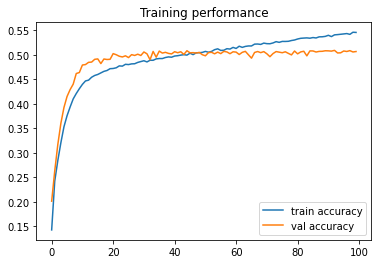

In [ ]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['accuracy'], label='train accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='val accuracy')
plt.legend()

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.2695610523223877
Test accuracy: 0.507099986076355


In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

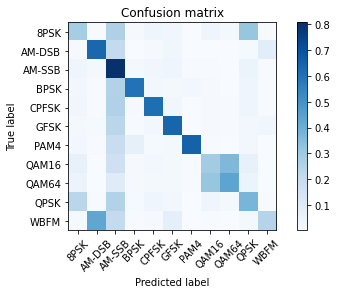

In [ ]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

Overall Accuracy:  0.09240622140896615
Overall Accuracy:  0.08846503178928247
Overall Accuracy:  0.09605643994211288
Overall Accuracy:  0.11313605196679899
Overall Accuracy:  0.1454876937101185
Overall Accuracy:  0.21663408565843256
Overall Accuracy:  0.3356604813521955
Overall Accuracy:  0.4809384164222874
Overall Accuracy:  0.5937153419593346
Overall Accuracy:  0.6743468795355588
Overall Accuracy:  0.7135036496350365
Overall Accuracy:  0.7122864412940749
Overall Accuracy:  0.7364170337738619
Overall Accuracy:  0.7287003610108304
Overall Accuracy:  0.7428313796212804
Overall Accuracy:  0.7428051001821494
Overall Accuracy:  0.7242440702516748
Overall Accuracy:  0.74423325336778
Overall Accuracy:  0.736289592760181
Overall Accuracy:  0.7305130513051306


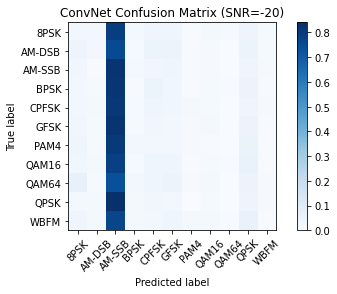

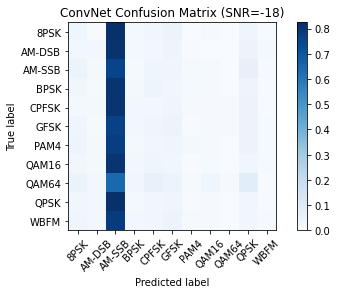

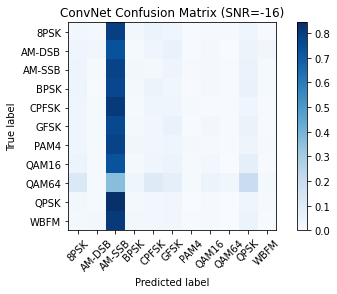

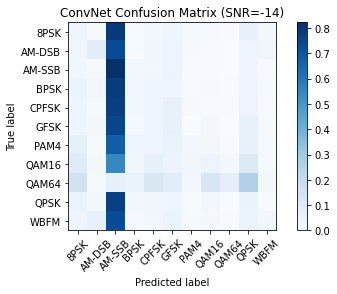

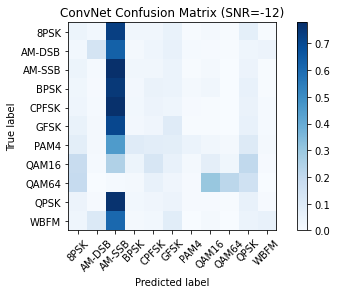

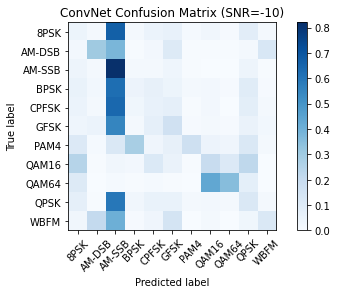

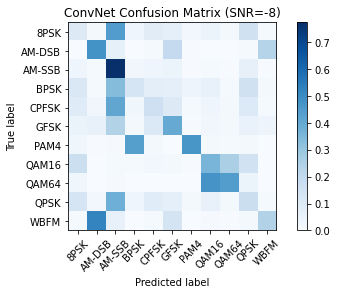

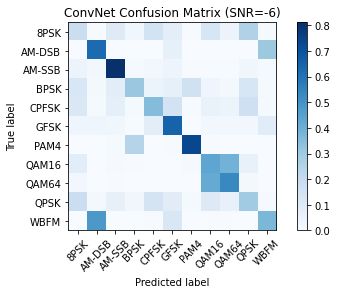

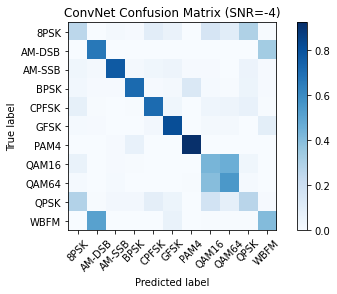

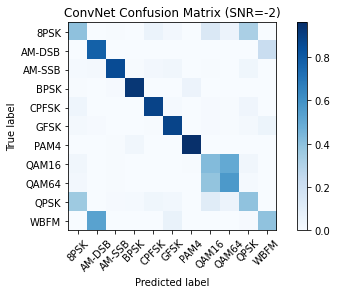

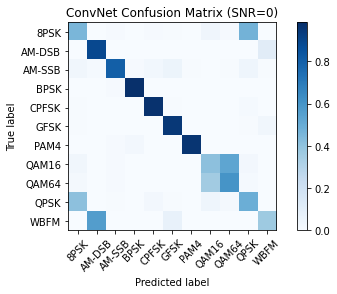

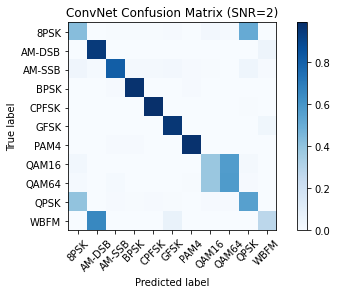

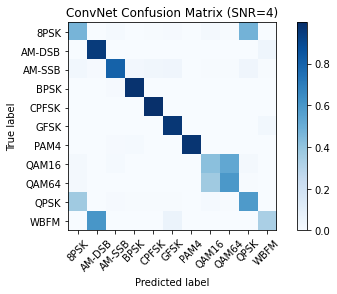

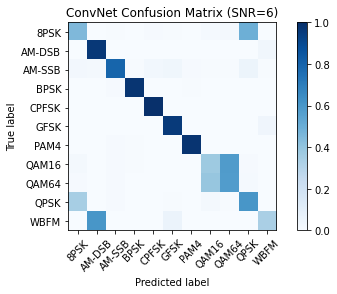

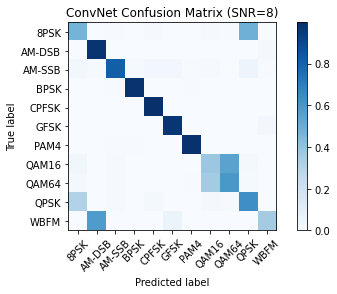

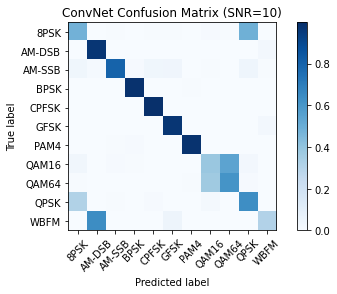

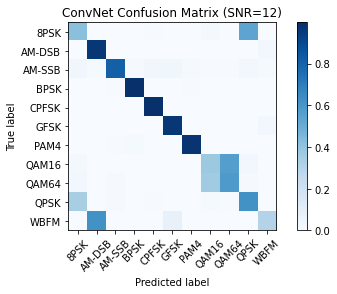

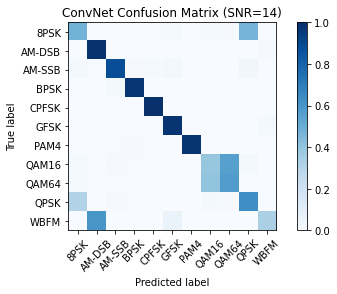

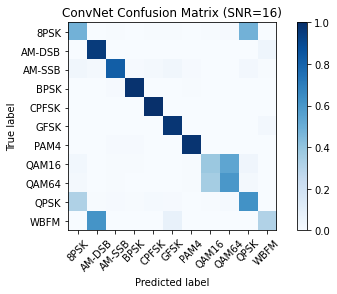

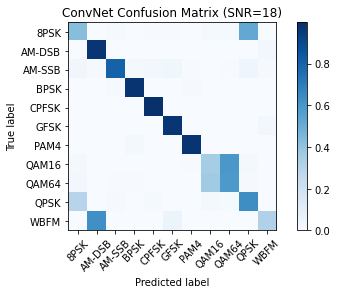

In [ ]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

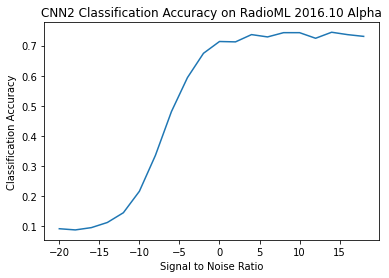

In [ ]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")